# Time Series Forecasting

**Author: Magali Solimano**

## Overview

First-time homeowners are looking to invest in residential real estate with the goal of maximizing returns  
over a 5y period. The buyers would like to identify the top 5 best zip codes to invest in.

## Business Understanding

This analysis will focus on zipcodes with below-median sales price and annual ROI 
(over previous 5 years)  
in the 90th percentile in the state of Florida, which exploratory data analysis shows has a high percentage  
of zipcodes that meet this criteria.

## Data

__Variable Descriptions__

- __RegionID__: Unique ID for each region

- __RegionName__: Zipcode

- __City__: City name

- __State__: State name

- __Metro__: Name of metro city around region

- __CountyName__: County name

- __SizeRank__: Rank by size of region

- __SalePrice__: Median sales price

## Loading data and libraries

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import itertools

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.arima import auto_arima


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv('data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# Examine shape of dataset
df.shape

(14723, 272)

In [4]:
# Examine number of unique values for all columns except time series columns
df.iloc[:, 0:7].nunique()

RegionID      14723
RegionName    14723
City           7554
State            51
Metro           701
CountyName     1212
SizeRank      14723
dtype: int64

Dataset has over 14,700 entries spanning a twenty-two year period from April 1996 to April 2018. The dataset  
includes 50 states and Washington, DC, and it covers 7,554 cities and 701 metro areas. 

Each row represents a zipcode, which is captured by RegionName in this dataset. Number of rows is  
equal to unique entries for RegionName.

## Exploratory Data Analysis and Visualization

In [5]:
# Rename columns: RegionName refers to zipcode, and CountyName can be renamed to County
df.rename({'RegionName': 'Zipcode'}, axis='columns', inplace=True)
df.rename({'CountyName': 'County'}, axis='columns', inplace=True)
# Set dtype to string
df.Zipcode = df.Zipcode.astype(str)
df.head()

,RegionID,Zipcode,City,State,Metro,County,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
df.dtypes

RegionID     int64
Zipcode     object
City        object
State       object
Metro       object
             ...  
2017-12      int64
2018-01      int64
2018-02      int64
2018-03      int64
2018-04      int64
Length: 272, dtype: object

- Zipcodes are in string format, which is the desired dtype for this analysis.

In [7]:
# Check for missing values by column
df.isnull().sum()

RegionID       0
Zipcode        0
City           0
State          0
Metro       1043
            ... 
2017-12        0
2018-01        0
2018-02        0
2018-03        0
2018-04        0
Length: 272, dtype: int64

Metro has missing values. The time series data is also likely to have missing values.

In [8]:
# Fill Metro na's with 'None'
df.Metro.fillna('None', inplace=True)

In [9]:
# Check for total missing values
df.isna().sum().sum()

156891

In [10]:
# Group zipcode by city, county, and state
df[['Zipcode','City','County','State']].sort_values(by=['Zipcode'])

,Zipcode,City,County,State
5850,1001,Agawam,Hampden,MA
20,10011,New York,New York,NY
508,10014,New York,New York,NY
4199,1002,Amherst,Hampshire,MA
272,10021,New York,New York,NY
...,...,...,...,...
4526,99709,Fairbanks,Fairbanks North Star,AK
8438,99712,Fairbanks,Fairbanks North Star,AK
4106,99801,Juneau,Juneau,AK
8658,99835,Sitka,Sitka,AK


A number of MA's zipcodes in the dataset only have four digits. Looking up the state's  
zipcodes, many start with '0', which appear to have been dropped in this dataset.

In [11]:
# Insert '0' as first digit in zipcodes with only four digits.
for i in range(len(df)):
    df.Zipcode[i] = df.Zipcode[i].rjust(5, '0')

# Return zipcode min to confirm that value now starts with '0'    
df.Zipcode.min()    

'01001'

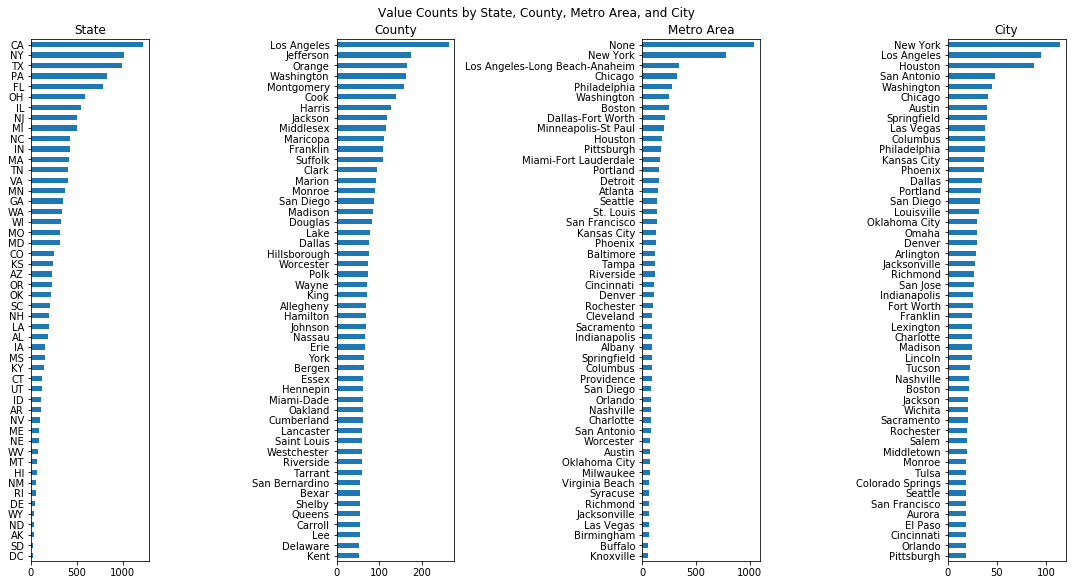

In [12]:
# Plot value counts by state, county, metro, and city
# Create figure and set size
fig, axes = plt.subplots(nrows=1 , ncols=4, figsize=(15,8))

# Plot value counts by state, metro, and city
df.State.value_counts().head(50).plot(kind='barh', title='State', ax = axes[0])
df.County.value_counts().head(50).plot(kind='barh', title='County', ax = axes[1])
df.Metro.value_counts().head(50).plot(kind='barh', title='Metro Area', ax = axes[2])
df.City.value_counts().head(50).plot(kind='barh', title='City', ax = axes[3])

# Invert y axes
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[2].invert_yaxis()
axes[3].invert_yaxis()

# Set title
plt.suptitle('Value Counts by State, County, Metro Area, and City', 
             y=1.01, fontsize=12)

# Format layout
plt.tight_layout()

In [13]:
# Search for missing data in time series columns
for col in reversed(df.columns):
    if df[col].isna().sum() > 0:
        print(col)
        break

2014-06


Data appears to be missing for some zipcodes in period leading up to June 2014.  
How many zipcodes are affected?

In [14]:
# Return zipcodes that have missing data in June 2014
print(len(df[df['2014-06'].isna()]))
df[df['2014-06'].isna()]

56


,RegionID,Zipcode,City,State,Metro,County,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2946,73623,35810,Huntsville,AL,Huntsville,Madison,2947,NaN,NaN,NaN,...,61000,61000,61100,61900,62800,63200,63700,65200,67500,69400
3330,58630,02116,Boston,MA,Boston,Suffolk,3331,NaN,NaN,NaN,...,1931100,1995600,2031100,2049600,2057800,2064500,2037600,2056900,2106500,2136500
6153,73629,35816,Huntsville,AL,Huntsville,Madison,6154,NaN,NaN,NaN,...,61500,62500,62800,63300,64100,65100,66600,68700,70400,71300
7587,78091,46320,Hammond,IN,Chicago,Lake,7588,NaN,NaN,NaN,...,66000,67900,68200,68700,69600,69400,68500,68500,68200,67200
7635,78566,47371,Portland,IN,None,Jay,7636,NaN,NaN,NaN,...,86300,86600,87400,88200,89100,90300,90400,89100,88000,88100
8263,88723,70647,Iowa,LA,Lake Charles,Calcasieu,8264,NaN,NaN,NaN,...,111600,117900,125300,128900,129600,130800,132100,132700,132400,132300
8338,73630,35824,Huntsville,AL,Huntsville,Madison,8339,NaN,NaN,NaN,...,217200,216800,216300,215100,215700,218200,222000,226200,230300,231800
8668,75206,39202,Jackson,MS,Jackson,Hinds,8669,NaN,NaN,NaN,...,152700,154300,155800,157500,158100,158300,158400,157900,156600,155300
8746,90561,74857,Norman,OK,Oklahoma City,Cleveland,8747,NaN,NaN,NaN,...,141800,141800,141700,141700,142000,143600,145600,145700,143900,141900
8780,78097,46327,Hammond,IN,Chicago,Lake,8781,NaN,NaN,NaN,...,75200,74600,73200,72500,72800,73200,72700,72900,74000,74400


- 56 zipcodes have missing data prior to June 2014

In [15]:
# Return mean and median prices in 2018 and 2013, and calculate percent change
# Mean and median price across all zipcodes in April 2018 and July 2014
print('Mean price, April 2018: $', np.round(df.groupby('Zipcode')['2018-04'].mean().mean()))
print('Median price, April 2018: $', df.groupby('Zipcode')['2018-04'].median().median())
print('------------------------------------------------')
# Mean and median price across all zipcodes in April 2013
print('Mean price, April 2013: $', np.round(df.groupby('Zipcode')['2013-04'].mean().mean()))
print('Median price, April 2013: $', df.groupby('Zipcode')['2013-04'].median().median())
print('------------------------------------------------')
# Price percentage change, 2018 vs. 2013
print('Mean price, percent change (2013-18): ', np.round(100*(288040-198100)/198100),'%')
print('Median price, percent change (2013-18): ', np.round(100*(211731-151200)/151200),'%')

Mean price, April 2018: $ 288040.0
Median price, April 2018: $ 198100.0
------------------------------------------------
Mean price, April 2013: $ 211731.0
Median price, April 2013: $ 151200.0
------------------------------------------------
Mean price, percent change (2013-18):  45.0 %
Median price, percent change (2013-18):  40.0 %


- Mean and median sales prices in the dataset have increased over 5y period.

In [16]:
# Calculate ROI metrics
# Cumulative 5-year ROI from 2013 to 2018
df['roi_cum'] = 100*(df['2018-04'] - df['2013-04']) / df['2013-04']

# Annual ROI for most recent 5 full years of data
df['roi_13-14'] = 100*(df['2014-04'] - df['2013-04']) / df['2013-04']
df['roi_14-15'] = 100*(df['2015-04'] - df['2014-04']) / df['2014-04']
df['roi_15-16'] = 100*(df['2016-04'] - df['2015-04']) / df['2015-04']
df['roi_16-17'] = 100*(df['2017-04'] - df['2016-04']) / df['2016-04']
df['roi_17-18'] = 100*(df['2018-04'] - df['2017-04']) / df['2017-04']

# Average annual ROI over 5-year period
df['roi_annual_avg_5y'] = (df['roi_13-14'] + df['roi_14-15'] + 
                           df['roi_15-16'] + df['roi_16-17'] + 
                           df['roi_17-18']) / 5

# Average annual ROI over 3-year period
df['roi_annual_avg_3y'] = (df['roi_15-16'] + 
                        df['roi_16-17'] + df['roi_17-18']) / 3

In [17]:
# Assess ROI metrics by zipcode
# Return median cumulative ROI for all zipcodes and by each zipcode
print('Median ROI from 2013-2018 (%): ', np.round(df.roi_cum.median(),2))

# Sort by highest average annual ROI
df.sort_values('roi_annual_avg_5y',ascending=False).head(10)[
                                    ['Zipcode','City','State',
                                     '2018-04','roi_cum',
                                     'roi_annual_avg_5y']]

Median ROI from 2013-2018 (%):  28.31


,Zipcode,City,State,2018-04,roi_cum,roi_annual_avg_5y
7302,80216,Denver,CO,267300,173.872951,22.475859
1477,94601,Oakland,CA,566700,167.943262,22.080962
5830,48240,Redford,MI,76800,161.224490,21.636195
2661,33705,Saint Petersburg,FL,177300,159.210526,21.271211
1239,94590,Vallejo,CA,376100,159.379310,21.140937
6105,37210,Nashville,TN,226500,155.932203,20.736401
2627,33460,Lake Worth,FL,215600,153.647059,20.645332
6563,15201,Pittsburgh,PA,185200,147.593583,20.424412
475,11216,New York,NY,1598700,147.591761,20.137008
1461,33461,Palm Springs,FL,198300,146.335404,19.902015


- Zipcodes in CO, CA (2), MI, FL (3), TN, PA, and NY have the highest median  
annual ROI over the 5y period.

In [18]:
# Descriptive statistics for average annual ROI
print(df.roi_annual_avg_5y.describe())
print('90%: ', df['roi_annual_avg_5y'].quantile(0.90))
print('95%: ', df['roi_annual_avg_5y'].quantile(0.95))
print('99%: ', df['roi_annual_avg_5y'].quantile(0.99))
print('99.9%: ', df['roi_annual_avg_5y'].quantile(0.999))

count    14572.000000
mean         5.837904
std          3.578349
min         -6.227148
25%          3.260563
50%          5.201242
75%          7.900593
max         22.475859
Name: roi_annual_avg_5y, dtype: float64
90%:  10.730895895726741
95%:  12.574402180728653
99%:  16.41122095614766
99.9%:  19.539471386916986


In [19]:
# Descriptive statistics for sales price in April 2018
print(df['2018-04'].describe())
print('20%: ', df['2018-04'].quantile(0.20))
print('90%: ', df['2018-04'].quantile(0.90))
print('95%: ', df['2018-04'].quantile(0.95))

count    1.472300e+04
mean     2.880399e+05
std      3.720544e+05
min      1.380000e+04
25%      1.324000e+05
50%      1.981000e+05
75%      3.211000e+05
max      1.789490e+07
Name: 2018-04, dtype: float64
20%:  119740.00000000001
90%:  539140.0000000003
95%:  763249.9999999999


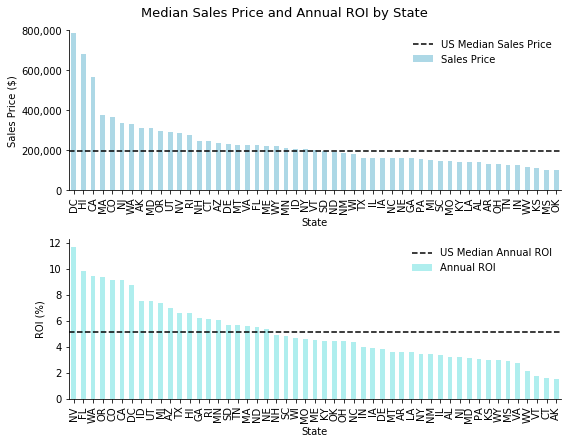

In [20]:
# Plot sales price and average annual ROI for all states
# Create figure and set size
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6))

# Plot average 2018 sales price by state
df.groupby('State')['2018-04'].median().sort_values(
                                                ascending=False).plot(
                                                kind='bar',
                                                color='lightblue',
                                                ax=ax[0])
# Plot average sales price for all states
ax[0].axhline(y=np.nanmedian(df['2018-04']), color='black', 
              linestyle='--')

# Set y-axis label and format y-axis ticks
ax[0].set_ylabel('Sales Price ($)')
ax[0].set(ylim=(0, 800000))
ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Add and format legend
price_labels = ['US Median Sales Price', 'Sales Price']

# Slice list to remove first handle
ax[0].legend(loc='topcenter', frameon=False, labels=price_labels)

# Plot median annual ROI by state
df.groupby('State')['roi_annual_avg_5y'].median().sort_values(
                                                ascending=False).plot(
                                                kind='bar',
                                                color='paleturquoise',
                                                ax=ax[1])

# Plot median annual ROI for all states
ax[1].axhline(y=np.nanmedian(df.roi_annual_avg_5y), color='black', 
             linestyle='--')

# Set y-axis label
ax[1].set_ylabel('ROI (%)')

# Add and format legend
roi_labels = ['US Median Annual ROI', 'Annual ROI']

# Slice list to remove first handle
ax[1].legend(labels = roi_labels, 
             loc='upper right', frameon=False)

# Set title
plt.suptitle('Median Sales Price and Annual ROI by State', fontsize='13',
            y=1.02)

# Format plot
sns.despine()
plt.tight_layout()

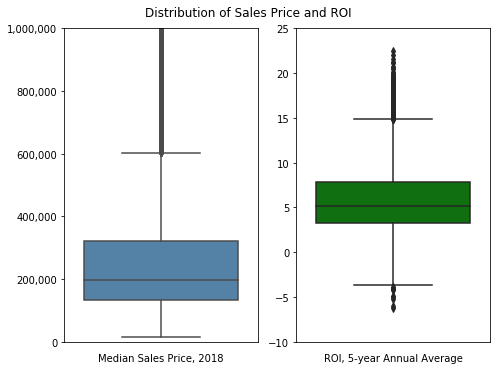

In [21]:
# Boxplots of 2018 median sales price and average annual ROI over 5-yr period

# Create figure and set size
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize = (7,5))

# Plot boxplots
sns.boxplot(data = df['2018-04'], color = 'steelblue', ax=ax[0]).set(
    xlabel='Median Sales Price, 2018')
sns.boxplot(data = df.roi_annual_avg_5y, color='green', ax=ax[1]).set(
    xlabel='ROI, 5-year Annual Average')

# Set y-axis range
ax[0].set(ylim=(0, 1000000))
ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax[1].set(ylim=(-10,25))

# Remove xticklabels and xticks
ax[0].set_xticklabels([])
ax[0].tick_params(bottom=False) 
ax[1].set_xticklabels([])
ax[1].tick_params(bottom=False) 

# Set title
plt.suptitle('Distribution of Sales Price and ROI', y = 1.02)
plt.tight_layout()

In [22]:
# Sort df by sales price and ROI criteria for business case
# Criteria: sales price between 20th and 50th percentiles and 
# ROI > 90th percentile
df[(df['2018-04'] >= np.percentile(df['2018-04'], 20)) & 
   (df['2018-04'] < np.percentile(df['2018-04'], 50)) & 
   (df['roi_annual_avg_5y'] > 10.73)].sort_values(
    by='roi_annual_avg_5y', ascending=False).head(15)

,RegionID,Zipcode,City,State,Metro,County,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,roi_cum,roi_13-14,roi_14-15,roi_15-16,roi_16-17,roi_17-18,roi_annual_avg_5y,roi_annual_avg_3y
2661,72768,33705,Saint Petersburg,FL,Tampa,Pinellas,2662,54600.0,54800.0,55000.0,...,175100,177300,159.210526,26.608187,5.427252,26.834611,22.538860,24.947146,21.271211,24.773539
6563,63932,15201,Pittsburgh,PA,Pittsburgh,Allegheny,6564,34400.0,34600.0,34700.0,...,179700,185200,147.593583,5.882353,28.409091,38.053097,11.965812,17.811705,20.424412,22.610205
990,72582,33415,Greenacres,FL,Miami-Fort Lauderdale,Palm Beach,991,70000.0,70100.0,70300.0,...,191100,193000,144.613435,22.813688,26.418989,20.326531,15.468114,13.396005,19.684665,16.396883
2988,72233,32807,Orlando,FL,Orlando,Orange,2989,68300.0,68400.0,68500.0,...,183800,186000,144.415243,19.316689,18.612335,20.241411,25.405405,14.532020,19.621572,20.059612
1463,73031,34207,Bradenton,FL,North Port-Sarasota-Bradenton,Manatee,1464,67600.0,67800.0,68000.0,...,163900,164700,141.495601,13.929619,11.325611,28.786127,27.917415,15.578947,19.507544,24.094163
3973,73243,34982,Fort Pierce,FL,Port St. Lucie,Saint Lucie,3974,64400.0,64600.0,64900.0,...,151900,152500,139.028213,13.166144,15.373961,32.893157,24.841915,10.347323,19.324500,22.694132
1946,94751,85035,Phoenix,AZ,Phoenix,Maricopa,1947,NaN,NaN,NaN,...,161000,161000,139.940387,31.147541,16.590909,20.857700,13.064516,14.835949,19.299323,16.252722
11874,71843,32180,Pierson,FL,Daytona Beach,Volusia,11875,59600.0,59500.0,59200.0,...,172600,173300,128.326746,22.529644,26.236559,-9.625213,39.019793,17.491525,19.130462,15.628702
2782,79092,48237,Oak Park,MI,Detroit,Oakland,2783,75200.0,75900.0,76600.0,...,128300,129600,137.798165,22.568807,25.149701,7.655502,22.000000,18.032787,19.081359,15.896096
7817,97297,93505,California City,CA,Bakersfield,Kern,7818,69400.0,68500.0,67600.0,...,139600,142700,135.090610,25.864909,10.340314,7.591934,31.973539,19.214703,18.997080,19.593392


- Many zipcodes in Florida emerge among top results according to criteria to focus on below-median sales  
price and annual average ROI (over previous 5 years) in the top 90th percentile.

In [23]:
# Create df for Florida zipcodes
df_fl = df.loc[df['State']=='FL']
df_fl.head()

,RegionID,Zipcode,City,State,Metro,County,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,roi_cum,roi_13-14,roi_14-15,roi_15-16,roi_16-17,roi_17-18,roi_annual_avg_5y,roi_annual_avg_3y
11,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0,100700.0,100400.0,...,249800,251800,21.878025,11.229429,6.222802,2.703810,-0.917431,1.368760,4.121474,1.051713
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1443900,1432300,59.730122,14.129586,20.793434,12.732568,5.159300,-2.265438,10.109890,5.208810
82,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0,111700.0,111800.0,...,296400,298200,78.029851,11.104478,14.562063,11.772983,16.617709,7.304786,12.272404,11.898493
83,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0,126800.0,126800.0,...,312600,313100,72.792494,21.081678,12.853236,9.491115,8.004426,6.933060,11.672703,8.142867
84,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0,480700.0,481200.0,...,2933600,2914100,67.554048,13.299218,18.888607,15.447987,7.202544,0.507001,11.069072,7.719178


In [24]:
# Descriptive statistics for FL zipcodes annual ROI, 5y period
print(df_fl['roi_annual_avg_5y'].describe())
print('90%: ', df_fl['roi_annual_avg_5y'].quantile(0.90))
print('95%: ', df_fl['roi_annual_avg_5y'].quantile(0.95))
print('99%: ', df_fl['roi_annual_avg_5y'].quantile(0.99))
print('99.9%: ', df_fl['roi_annual_avg_5y'].quantile(0.999))

count    783.000000
mean      10.439557
std        3.743364
min        1.693136
25%        7.764116
50%        9.858630
75%       12.540648
max       21.271211
Name: roi_annual_avg_5y, dtype: float64
90%:  15.9556245370342
95%:  17.87985008826843
99%:  19.40133774902879
99.9%:  20.78177396732554


In [25]:
# Descriptive statistics for FL zipcodes annual ROI, 3y period
print(df_fl['roi_annual_avg_3y'].describe())
print('90%: ', df_fl['roi_annual_avg_3y'].quantile(0.90))
print('95%: ', df_fl['roi_annual_avg_3y'].quantile(0.95))
print('99%: ', df_fl['roi_annual_avg_3y'].quantile(0.99))
print('99.9%: ', df_fl['roi_annual_avg_3y'].quantile(0.999))

count    785.000000
mean      10.739773
std        4.714136
min        0.533842
25%        7.244962
50%       10.017296
75%       13.654176
max       24.773539
Name: roi_annual_avg_3y, dtype: float64
90%:  17.36673335000142
95%:  19.487818071708187
99%:  23.201578293128918
99.9%:  24.546827790203913


In [26]:
# Descriptive statistics for FL zipcodes 2018 sales price
print(df_fl['2018-04'].describe())
print('10%: ', df_fl['2018-04'].quantile(0.10))
print('20%: ', df_fl['2018-04'].quantile(0.20))
print('90%: ', df_fl['2018-04'].quantile(0.90))
print('95%: ', df_fl['2018-04'].quantile(0.95))

count    7.850000e+02
mean     2.881916e+05
std      2.893817e+05
min      4.770000e+04
25%      1.682000e+05
50%      2.261000e+05
75%      3.198000e+05
max      4.686200e+06
Name: 2018-04, dtype: float64
10%:  122280.0
20%:  160460.0
90%:  453160.0000000002
95%:  618299.9999999997


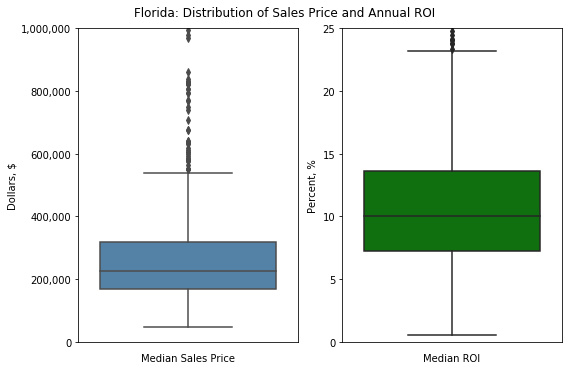

In [27]:
# Plot boxplot for FL zipcodes annual ROI
# Create figure and set size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5)) 

# Plot price boxplot
sns.boxplot(df_fl['2018-04'], orient='v', color='steelblue', ax=ax[0]).set(
    xlabel='Median Sales Price') 

# Plot ROI boxplot
sns.boxplot(df_fl['roi_annual_avg_3y'], orient='v', color='green', ax=ax[1]
           ).set(xlabel='Median ROI')

# Set y-axis ranges and labels for subplots
ax[0].set(ylim=(0, 1000000))
ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax[0].set_ylabel('Dollars, $')
ax[1].set(ylim=(0,25))
ax[1].set_ylabel('Percent, %')

# Remove xticklabels and xticks
ax[0].set_xticklabels([])
ax[0].tick_params(bottom=False) 
ax[1].set_xticklabels([])
ax[1].tick_params(bottom=False) 

# Set title
plt.suptitle('Florida: Distribution of Sales Price and Annual ROI', y=1.02)
plt.tight_layout()

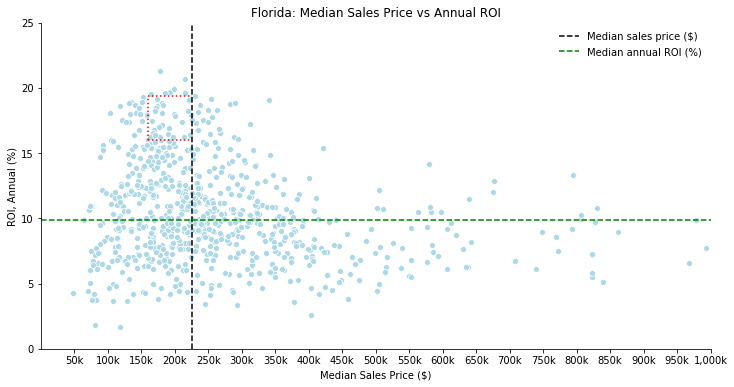

In [28]:
# Scatterplot of FL sales price and annual ROI tailored for business case
# Create figure and set size
plt.figure(figsize=(12,6))

# Scatterplot of median price and roi
sns.scatterplot(data=df_fl, x='2018-04', y='roi_annual_avg_5y', color='lightblue')

# Plot 50th percentile sales price
plt.vlines(226100, 0, 40, color='black', linestyles='dashed',
          label='Median sales price ($)')

# Plot 50th percentile average annual 5yr ROI
plt.hlines(9.85, 0, 1000000, color='green', linestyles='dashed',
          label='Median annual ROI (%)')

# Set x-axis scale and ticks
plt.xlim(0,350000)
plt.xticks([50000,100000,150000,200000,250000,300000,350000,400000,450000,
            500000,550000,600000,650000,700000,750000,800000,850000,900000,
            950000,1000000],
           ['50k','100k','150k','200k','250k','300k', '350k', '400k', '450k',
           '500k', '550k','600k', '650k', '700k', '750k', '800k', '850k',
            '900k', '950k','1,000k'])
plt.xlabel('Median Sales Price ($)')

# Set y-axis scale and ticks
plt.ylim(0, 25)
plt.yticks([0, 5, 10, 15, 20, 25])
plt.ylabel('ROI, Annual (%)')

# Plot box highlighting target group with prices b/w 20th and 50th percentiles
# and ROI > 90th percentile and < 99th percentile
plt.vlines(160460, 15.995, 19.4, color='red', linestyles='dotted')
plt.hlines(15.995, 160460, 226100, color='red', linestyles='dotted')
#plt.hlines(17.87, 160460, 226100, color='red', linestyles='dotted')
plt.hlines(19.4, 160460, 226100, color='red', linestyles='dotted')

# Add and format legend
plt.legend(loc='upper right', frameon=False)

# Add title
plt.title('Florida: Median Sales Price vs Annual ROI')

# Remove borders
sns.despine()

plt.show()

## Data Preprocessing

In [29]:
# Create subset df according to selection criteria:
# State of Florida 
# Sales price between 20th and 50th percentiles and 
# ROI > 90 percentile and < 99th percentiles (to remove 'hot market' outliers)
# Sort by annual avg ROI over 5y period.
zillow_select = df_fl[(df_fl['2018-04'] >= 
                       np.percentile(df_fl['2018-04'], 20)) & 
                      (df_fl['2018-04'] < np.percentile(df['2018-04'], 50)) & 
                      (df_fl['roi_annual_avg_5y'] > 15.955) & 
                      (df['roi_annual_avg_5y'] < 19.4)].sort_values(
    by='roi_annual_avg_5y', ascending=False).head(10)
zillow_select

,RegionID,Zipcode,City,State,Metro,County,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,roi_cum,roi_13-14,roi_14-15,roi_15-16,roi_16-17,roi_17-18,roi_annual_avg_5y,roi_annual_avg_3y
11874,71843,32180,Pierson,FL,Daytona Beach,Volusia,11875,59600.0,59500.0,59200.0,...,172600,173300,128.326746,22.529644,26.236559,-9.625213,39.019793,17.491525,19.130462,15.628702
763,72717,33614,Egypt Lake-Leto,FL,Tampa,Hillsborough,764,60800.0,60700.0,60800.0,...,179300,181000,135.370611,27.698309,10.285132,22.160665,20.710506,13.337508,18.838424,18.736226
2439,72776,33713,Saint Petersburg,FL,Tampa,Pinellas,2440,52600.0,52500.0,52300.0,...,179400,182400,135.354839,16.000000,14.460512,23.129252,22.257301,17.753389,18.720091,21.046647
585,72262,32839,Orlando,FL,Orlando,Orange,586,73800.0,73700.0,73600.0,...,171900,173800,134.231806,24.258760,15.075922,13.760603,16.652858,23.437500,18.637129,17.950321
2065,73029,34205,Bradenton,FL,North Port-Sarasota-Bradenton,Manatee,2066,70400.0,70600.0,70700.0,...,169900,171700,132.341001,17.861976,13.203215,24.340771,24.225122,12.738017,18.473820,20.434637
2828,72398,33069,Pompano Beach,FL,Miami-Fort Lauderdale,Broward,2829,63300.0,63100.0,62900.0,...,168000,170300,129.205922,18.034993,7.753706,14.708995,28.505535,22.254128,18.251471,21.822886
8259,71858,32204,Jacksonville,FL,Jacksonville,Duval,8260,41400.0,41400.0,41500.0,...,181200,180900,127.833753,21.410579,30.082988,13.476874,12.930429,12.570006,18.094175,12.992436
3146,72574,33407,West Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,3147,58400.0,58300.0,58300.0,...,164800,166400,122.459893,27.673797,10.575916,18.844697,13.545817,16.771930,17.482431,16.387481
2745,72236,32810,Lockhart,FL,Orlando,Orange,2746,72200.0,72300.0,72400.0,...,177800,180400,118.137848,22.853688,2.755906,18.103448,25.952960,16.162267,17.165654,20.072892
5360,72929,33948,Port Charlotte,FL,Punta Gorda,Charlotte,5361,67800.0,67400.0,67000.0,...,175100,176200,118.339529,23.420074,16.365462,21.829163,9.065156,14.415584,17.019088,15.103301


### Convert to datetime

In [30]:
# Convert date columns to datetime dtype
# Starter function
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[:], format='%Y-%m')

In [31]:
# Select date columns only and pass them through function
zillow_select_date_df = zillow_select.iloc[:,8:-8]
zillow_select_date_df.columns = list(get_datetimes(zillow_select_date_df))
# Check dtype, which should be datetime
zillow_select_date_df.columns

DatetimeIndex(['1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
               '1997-01-01', '1997-02-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=264, freq=None)

In [32]:
# Concat dfs (7 informational columns, 9 roi columns, date columns)
zillow_select_df = pd.concat([zillow_select.iloc[:, :7], zillow_select.iloc[:, -8:], zillow_select_date_df], axis=1)
zillow_select_df

,RegionID,Zipcode,City,State,Metro,County,SizeRank,roi_cum,roi_13-14,roi_14-15,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
11874,71843,32180,Pierson,FL,Daytona Beach,Volusia,11875,128.326746,22.529644,26.236559,...,154100,155900,157200,160700,164500,166000,167600,170400,172600,173300
763,72717,33614,Egypt Lake-Leto,FL,Tampa,Hillsborough,764,135.370611,27.698309,10.285132,...,163700,165600,166600,167900,170000,172500,174600,177000,179300,181000
2439,72776,33713,Saint Petersburg,FL,Tampa,Pinellas,2440,135.354839,16.000000,14.460512,...,163000,166300,169300,171300,172000,172700,173500,175700,179400,182400
585,72262,32839,Orlando,FL,Orlando,Orange,586,134.231806,24.258760,15.075922,...,148200,150900,153400,156100,160300,164800,167700,169800,171900,173800
2065,73029,34205,Bradenton,FL,North Port-Sarasota-Bradenton,Manatee,2066,132.341001,17.861976,13.203215,...,158800,161100,162900,163800,164500,165600,166500,167800,169900,171700
2828,72398,33069,Pompano Beach,FL,Miami-Fort Lauderdale,Broward,2829,129.205922,18.034993,7.753706,...,147500,151800,155300,158100,160200,162300,164400,165900,168000,170300
8259,71858,32204,Jacksonville,FL,Jacksonville,Duval,8260,127.833753,21.410579,30.082988,...,161300,161600,163000,166400,169000,170400,174000,178700,181200,180900
3146,72574,33407,West Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,3147,122.459893,27.673797,10.575916,...,147600,150900,154100,156500,158200,159900,161700,163000,164800,166400
2745,72236,32810,Lockhart,FL,Orlando,Orange,2746,118.137848,22.853688,2.755906,...,160700,162100,163400,164700,167100,170400,172700,174900,177800,180400
5360,72929,33948,Port Charlotte,FL,Punta Gorda,Charlotte,5361,118.339529,23.420074,16.365462,...,161700,163200,164500,165800,167200,169100,171100,173100,175100,176200


In [33]:
# Create df for each zipcode selected for this phase of analysis
pierson = zillow_select_df[zillow_select_df['Zipcode']=='32180']
egyptlakeleto = zillow_select_df[zillow_select_df['Zipcode']=='33614']
stpete = zillow_select_df[zillow_select_df['Zipcode']=='33713']
orlando = zillow_select_df[zillow_select_df['Zipcode']=='32839']
bradenton = zillow_select_df[zillow_select_df['Zipcode']=='34205']
pompanobeach = zillow_select_df[zillow_select_df['Zipcode']=='33069']
jacksonville = zillow_select_df[zillow_select_df['Zipcode']=='32204']
westpalmbeach = zillow_select_df[zillow_select_df['Zipcode']=='33407']
lockhart = zillow_select_df[zillow_select_df['Zipcode']=='32810']
portcharlotte = zillow_select_df[zillow_select_df['Zipcode']=='33948']

In [34]:
# Create list of select FL dfs
fl_list = [pierson, egyptlakeleto, stpete, orlando, bradenton,
           pompanobeach, jacksonville, westpalmbeach, lockhart, portcharlotte]

### Reshape dataset

In [35]:
# Reshape from wide to long format
def melt_data(df):
    """
    Takes the data dataset in wide form. Returns long-form datetime dataframe 
    with datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passed in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID','Zipcode','City','State','Metro',
                                  'County','SizeRank','roi_cum','roi_13-14',
                                  'roi_14-15','roi_15-16','roi_16-17',
                                  'roi_17-18','roi_annual_avg_5y',
                                  'roi_annual_avg_3y'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [36]:
# Apply function to melt dfs
pierson_ts_full = melt_data(pierson) 
egyptlakeleto_ts_full = melt_data(egyptlakeleto)
stpete_ts_full = melt_data(stpete)
orlando_ts_full = melt_data(orlando)
bradenton_ts_full = melt_data(bradenton)
pompanobeach_ts_full = melt_data(pompanobeach)
jacksonville_ts_full = melt_data(jacksonville)
westpalmbeach_ts_full = melt_data(westpalmbeach)
lockhart_ts_full = melt_data(lockhart)
portcharlotte_ts_full = melt_data(portcharlotte)

# Calculate new dfs with 12-month returns in percent change (%) and return df  
# without first twelve nan rows
pierson_ts = pierson_ts_full.pct_change(12).iloc[12:]
egyptlakeleto_ts =  egyptlakeleto_ts_full.pct_change(12).iloc[12:]
stpete_ts = stpete_ts_full.pct_change(12).iloc[12:]
orlando_ts = orlando_ts_full.pct_change(12).iloc[12:]
bradenton_ts = bradenton_ts_full.pct_change(12).iloc[12:]
pompanobeach_ts = pompanobeach_ts_full.pct_change(12).iloc[12:]
jacksonville_ts = jacksonville_ts_full.pct_change(12).iloc[12:]
westpalmbeach_ts = westpalmbeach_ts_full.pct_change(12).iloc[12:]
lockhart_ts = lockhart_ts_full.pct_change(12).iloc[12:]
portcharlotte_ts = portcharlotte_ts_full.pct_change(12).iloc[12:]

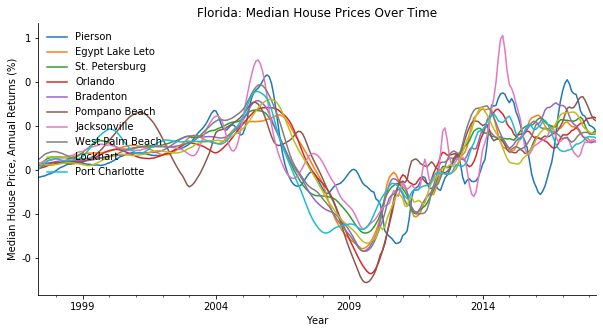

In [37]:
# Create df with all melted city dfs' *annual returns* and plot all series in one graph
# List of time series dfs
ts_list = [pierson_ts, egyptlakeleto_ts, stpete_ts, orlando_ts, 
           bradenton_ts, pompanobeach_ts, jacksonville_ts, 
           westpalmbeach_ts, lockhart_ts, portcharlotte_ts]

# Concat dfs into one df
ts_df = pd.concat(ts_list, axis=1)

# Rename columns
names = ['Pierson', 'Egypt Lake Leto', 'St. Petersburg', 'Orlando', 
             'Bradenton', 'Pompano Beach', 'Jacksonville', 'West Palm Beach',
            'Lockhart', 'Port Charlotte']
ts_df.columns = names

# Plot series
fig, ax = plt.subplots(figsize=(10,5))
ts_df.plot(ax=ax)
# Set x and y axis labels
plt.xlabel('Year')
plt.ylabel('Median House Price, Annual Returns (%)')
# Format y-ticks
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Set title
plt.title('Florida: Median House Prices Over Time')
# Format legend
ax.legend(loc='upper left', frameon=False)
# Remove borders
sns.despine()

plt.show()

- Times series are not stationary. There appear to be cyclical and upward trends.

In [38]:
# Filter time series to focus on post housing crisis period 2011 onwards
# pierson_ts = pierson_ts_full['2011':'2018']
# egyptlakeleto_ts = egyptlakeleto_ts_full['2011':'2018']
# stpete_ts = stpete_ts_full['2011':'2018']
# orlando_ts = orlando_ts_full['2011':'2018']
# bradenton_ts = bradenton_ts_full['2011':'2018']
# pompanobeach_ts = pompanobeach_ts_full['2011':'2018']
# jacksonville_ts = jacksonville_ts_full['2011':'2018']
# westpalmbeach_ts = westpalmbeach_ts_full['2011':'2018']
# lockhart_ts = lockhart_ts_full['2011':'2018']
# portcharlotte_ts = portcharlotte_ts_full['2011':'2018']

# # Create list of filtered df
# ts_filter_list = [pierson_ts, egyptlakeleto_ts, stpete_ts, orlando_ts, 
#            bradenton_ts, pompanobeach_ts, jacksonville_ts, 
#            westpalmbeach_ts, lockhart_ts, portcharlotte_ts]

## SARIMAX Modeling

### Train-test-split

In [39]:
# Define function to apply train_test_split to all selected dfs
def tt_split(df_list, names):
    tts_list = []
    
    for i, df in enumerate(df_list):
        train_data = df[:-12] #all data, except last 12 months
        test_data = df[-12:] #last 12 months of data
        tts_list.extend([train_data, test_data])
        print(names[i],':', df.shape, ' // Train: ', train_data.shape,
             'Test: ', test_data.shape)
    return tts_list    #return list of train, test dfs

In [40]:
# Split dfs into train and test sets
pierson_train, pierson_test, egyptlakeleto_train, egyptlakeleto_test, \
    stpete_train, stpete_test, orlando_train, orlando_test, \
    bradenton_train, bradenton_test, pompanobeach_train, pompanobeach_test,\
    jacksonville_train, jacksonville_test, westpalmbeach_train, westpalmbeach_test,\
    lockhart_train, lockhart_test, portcharlotte_train, portcharlotte_test \
    = tt_split(ts_list, names)

Pierson : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
Egypt Lake Leto : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
St. Petersburg : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
Orlando : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
Bradenton : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
Pompano Beach : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
Jacksonville : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
West Palm Beach : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
Lockhart : (252, 1)  // Train:  (240, 1) Test:  (12, 1)
Port Charlotte : (252, 1)  // Train:  (240, 1) Test:  (12, 1)


In [41]:
# Create train list and test list
train_dfs = [pierson_train, egyptlakeleto_train, stpete_train, orlando_train,
             bradenton_train, pompanobeach_train, jacksonville_train,
             westpalmbeach_train, lockhart_train, portcharlotte_train]
test_dfs = [pierson_test, egyptlakeleto_test, stpete_test, orlando_test,
             bradenton_test, pompanobeach_test, jacksonville_test,
             westpalmbeach_test, lockhart_test, portcharlotte_test]

### Define functions

In [42]:
# Define function to plot autocorrelation function (ACF) and 
# partial autocorrelation function (PACF)

def plot_acf_pacf(name, ts):
    # Create figure, set format and size
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    plot_acf(ts.dropna(), ax[0]) #plot ACF
    ax[0].xaxis.set_major_locator(plt.MultipleLocator(2)) #set xtick frequency
    ax[0].set_xlabel('Lag') #set xlabel
    ax[0].set_ylabel('Autocorrelation') #set ylabel

    plot_pacf(ts.dropna(), ax[1]) #plot PACF
    ax[1].set_xlim(-1,21) #set x-axis range
    ax[1].xaxis.set_major_locator(plt.MultipleLocator(1)) #set xtick frequency
    ax[1].set_xlabel('Lag') #set xlabel
    ax[1].set_ylabel('Partial Autocorrelation') #set ylabel
    
    plt.suptitle(name)

    plt.tight_layout()

In [43]:
# Define function to check for stationarity
def stationarity_check(ts):
    """Calculate 12m rolling statistics and plot against original time series, 
    and perform and return Dickey Fuller test"""
    
    print('Results of Dickey-Fuller Test: \n')
        
    # Calculate rolling mean and standard deviation
    rolling_mean = ts.rolling(window=12, center=False).mean()
    rolling_std = ts.rolling(window=12, center=False).std()
        
    # Perform the Dickey Fuller Test
    df_test = adfuller(ts['value'].dropna())
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(8,5))
    plt.plot(ts, color='black', label='Original')
    plt.plot(rolling_mean.dropna(), color='blue', label='Rolling Mean, 12-month', 
             linestyle='dotted')
    plt.plot(rolling_std.dropna(), color='green', 
             label = 'Rolling Std, 12-month',
             linestyle='dotted')
    
    # Format y-ticks
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    
    # Add legend
    plt.legend(loc='best')
    # Add title
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             'Number of Lags Used', 
                                             'Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)
    
    return None

In [44]:
# Define function to fit baseline SARIMAX model and print results
# p = 1, d = 1 , m = 1, s=12

def fit_baseline_sarimax_model(metrics_df, name, train, order=(1,1,1),
                               seasonal_order=(0,0,0,12)):
    
    # Instantiate model
    arima_model = sm.tsa.statespace.SARIMAX(train.dropna(),
                                           order=order,
                                           seasonal_order=seasonal_order)
    # Fit model
    output = arima_model.fit()
    
    # obtain comp metrics
    comp_metrics = [name, order, seasonal_order]
    # append AIC score
    comp_metrics.append(round(output.aic, 2))
    # add selected output metrics to df
    metrics_columns = ['Name', 'Baseline_Order', 'Baseline_Seasonal_Order','Baseline_AIC_Score']
    metrics_df = pd.DataFrame(comp_metrics).T
    metrics_df.columns = metrics_columns

    return metrics_df

    # Print results
    #display(output.summary())
    #output.plot_diagnostics(figsize=(11,8))
    
    #return output

In [45]:
# Define function to find best parameters for SARIMAX model using auto_arima
"""parameters: m=12 months, trend='ct' (constant and linear), time series is 
seasonal and is not stationary"""

def find_params(name, ts):  
    params_output = pm.auto_arima(ts.dropna(), start_p=1, start_d=0, start_q=1, 
                                  max_p=4, max_d=2, max_q=4,
                                m=12, seasonal=True, stationary=False,
                                stepwise=True, trend='ct',
                                information_criterion='aic',  
                                scoring='mse',  
                                suppress_warnings=True, trace=False, 
                                error_action='ignore')
   
    return name, params_output.order, params_output.seasonal_order, round(
        params_output.aic(),1)

In [46]:
# Define function to fit SARIMAX model, print results, and calculate RMSE for
# predictions
# p = 1, d = 1, m = 1 per ACF, PCF plots and ADF stationarity check

def fit_sarimax_model(train, test, order=(1,1,1), seasonal_order=(0,0,0,12)):
    # Instantiate model
    arima_model = sm.tsa.statespace.SARIMAX(train.dropna(),
                                           order=order,
                                           seasonal_order=seasonal_order,
                                           enforce_stationarity=True,
                                           enforce_invertibility=False)
    # Fit model
    model_output = arima_model.fit()
    
    # Print results
    display(model_output.summary())
    model_output.plot_diagnostics(figsize=(8,8));

    # Calculate predictions
    # Calculate predictions from 2017-05 and calculate 95% confidence interval
    prediction = model_output.get_prediction(start=pd.to_datetime('2017-05'),
                                             end=pd.to_datetime('2018-04'),
                                            dynamic=False)
    pred_ci = prediction.conf_int(alpha=0.05)
    
    # Calculate RMSE for last year of actual data vs prediction
    # Use test set for last year of data
    rmse = sqrt(mean_squared_error(test.value, prediction.predicted_mean))
    print('======================================================')
    print('Root Mean Squared Error of predictions is {}'.format(round(rmse, 2)),'percentage points')
    print('======================================================')
    return model_output

In [47]:
# Define function to calculate predictions and forecasts
"""Calculates forecasts for next 36 months, starting from April 2018. 
Plots forecasts."""
def get_forecasts(name, train, test, model_output, steps=36):

    # Calculate forecast and 95% confidence interval for steps in future
    future = model_output.get_forecast(steps=steps, dynamic=True)
    future_ci = future.conf_int()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6,5))
    # Plot observed values
    all_data = pd.concat([train, test])
    all_data['2011':].plot(label='Actual', color='blue', ax=ax)
    
    # Plot predicted values
    prediction = model_output.get_prediction(start=pd.to_datetime('2011-01'),
                                             end=pd.to_datetime('2018-04'))
    prediction.predicted_mean.plot(color='lightblue', linewidth=1.5, ax=ax)
    prediction_ci = prediction.conf_int()
#     plt.fill_between(np.exp(prediction_ci).index,
#                    np.exp(prediction_ci).iloc[:, 0],
#                    np.exp(prediction_ci).iloc[:, 1], color='lightblue', 
#                     alpha=.5)
    
    # Plot forecasted values
    future.predicted_mean.plot(color='darkorange', linestyle='dotted', ax=ax)

    # Prediction for forecast period and confidence interval
    forecast = future.predicted_mean[-1]
    maximum = future_ci.iloc[-1,1]
    minimum = future_ci.iloc[-1,0]
    predictions = {}
    predictions['forecast'] = forecast
    predictions['maximum'] = maximum
    predictions['minimum'] = minimum

    plt.fill_between(future_ci.index,
                    future_ci.iloc[:, 0],
                    future_ci.iloc[:, 1], color='orange', alpha=.15)
    
    # Plot zero values
    plt.hlines(0, '2011', '2023', color='black')
    
    # Format y-axis range
    ax.yaxis.set_ticks(np.arange(-0.3, 0.7, 0.1))
    # Set axes labels
    ax.set_ylabel('Annual return (percentage points)')
    ax.set_xlabel('')
    # Format ticks
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    # Format gridlines
    plt.grid(axis='y')
    # Remove top, right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set titles and legend
    plt.suptitle(f'{name}: Predicted Mean Annual Return', y=1.02)
    plt.legend(['Actual', 'Predicted','Forecast'], loc='upper left', frameon=False)
    
    plt.tight_layout()
    plt.show();

### ACF and PACF

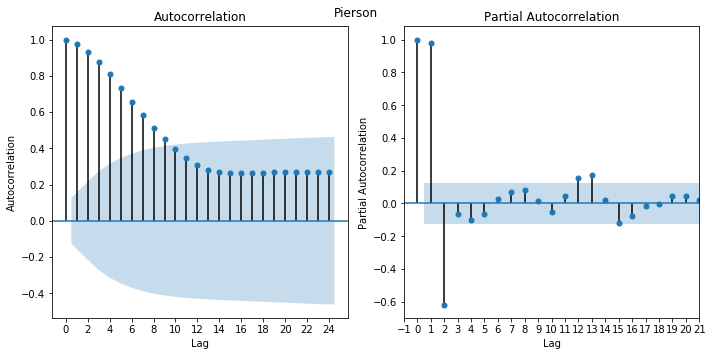

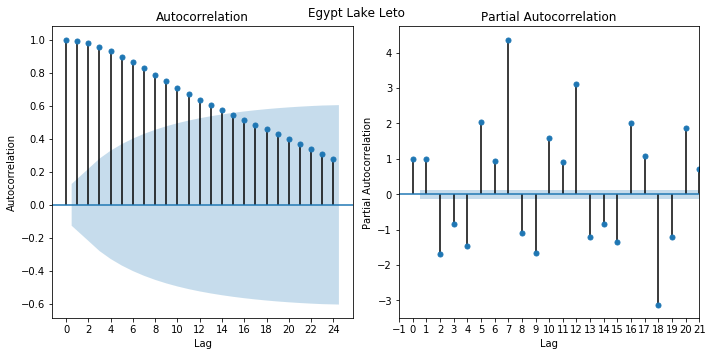

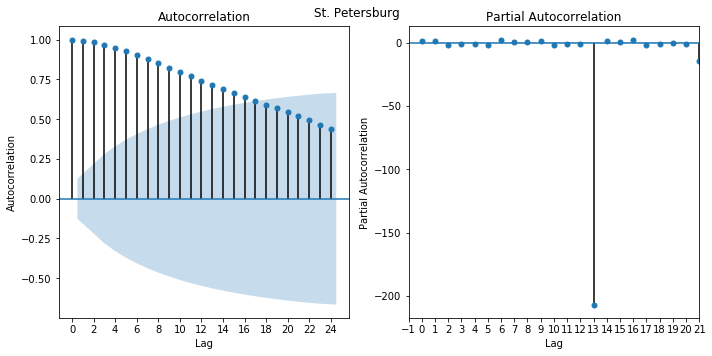

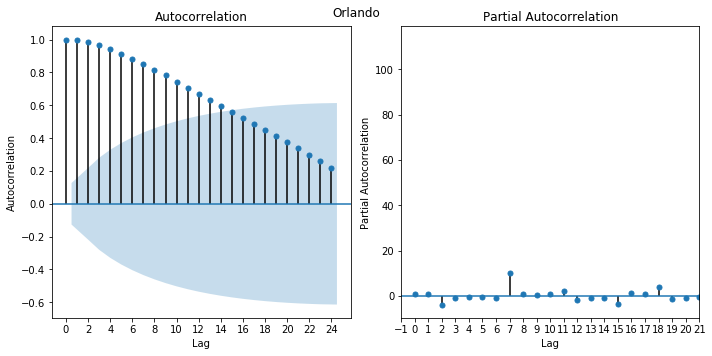

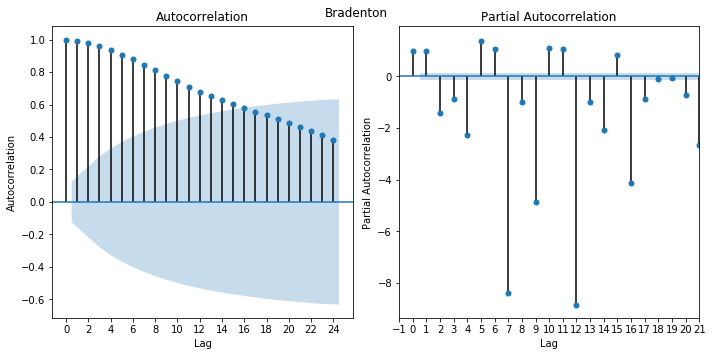

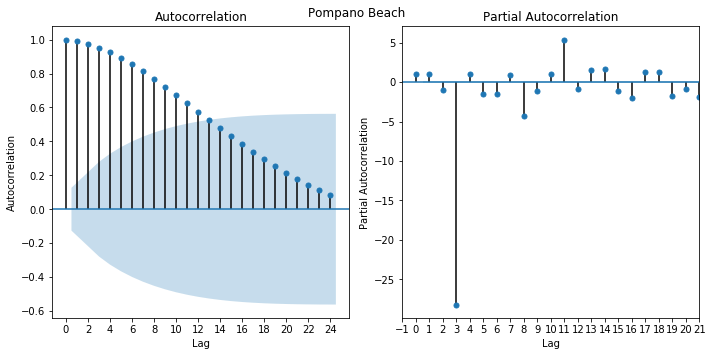

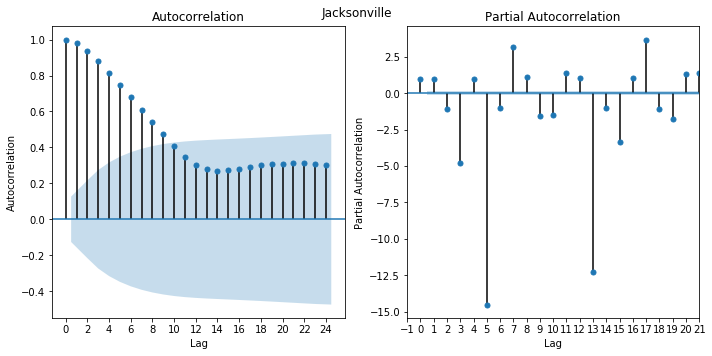

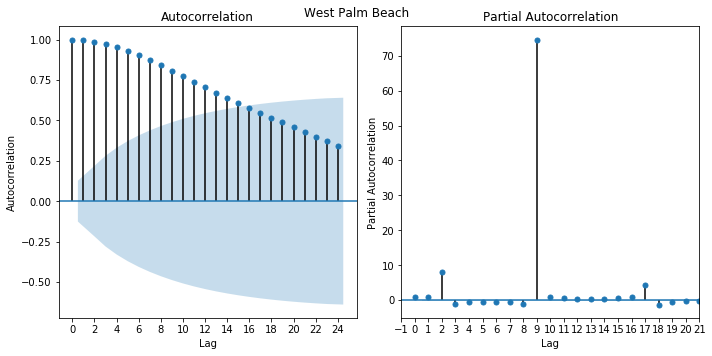

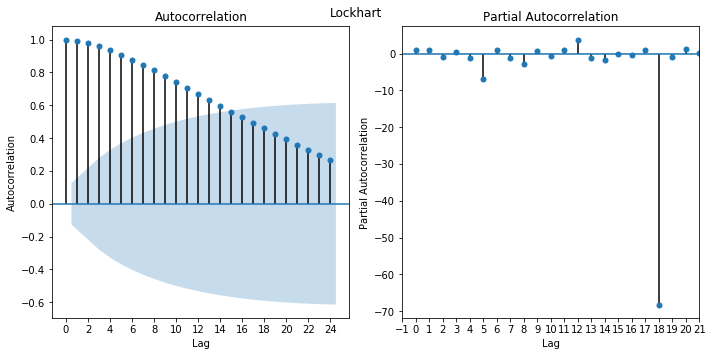

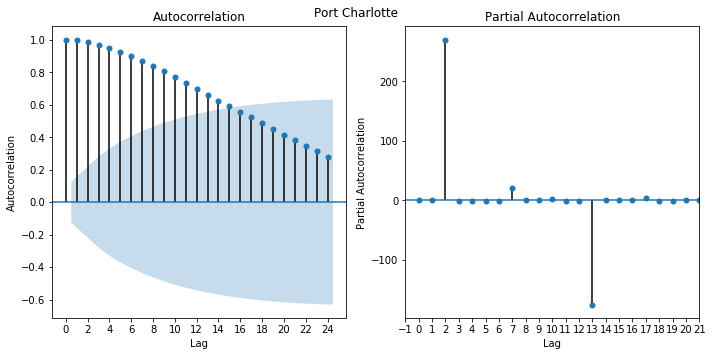

In [48]:
# Plot ACF and PCF for all time series
for i, train_df in enumerate(train_dfs): 
    plot_acf_pacf(names[i], train_df)

- All zipcodes have comparable ACF plots. In ACF plots, previous sales price influences current sales price,  
but the significance decreases slowly. The first 6-8 lags are significant at 5% significance level (95% CI).  
- For most zipcodes, the PACF plot indicates that partial autocorrelations for lags 0, 1, and 2 are statistically  
significant. Thus, the PACF suggests fitting a first- or second-order autoregressive (AR) model. The lag of 1  
has significant spike and then drops off.
- PACF plots vary. They have spikes in the middle/end of PACF that suggest there is seasonality to consider.
- Autoregressive model is appropriate. According to PACF, the 'p' component could have a range of values.

### Stationarity

Results of Dickey-Fuller Test: 



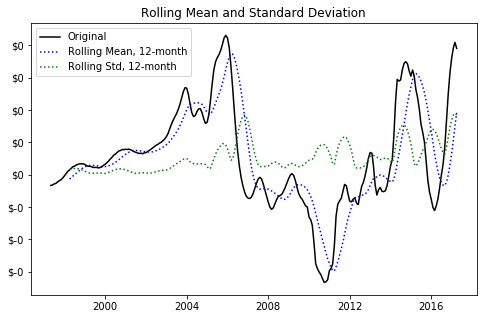

Results of Dickey-Fuller Test: 

Test Statistic                  -2.256497
p-value                          0.186383
Number of Lags Used             15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [49]:
# Check for stationarity
stationarity_check(pierson_train)

- p-value > 0.05 critical value. Time series is not stationary; there are trends in the data.

Results of Dickey-Fuller Test: 



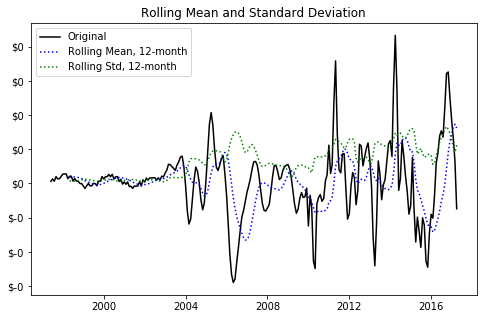

Results of Dickey-Fuller Test: 

Test Statistic                  -3.619342
p-value                          0.005402
Number of Lags Used             14.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [50]:
# Difference the time series and recheck stationarity of differenced series
pierson_train_diff = pierson_train.diff(1).dropna()
stationarity_check(pierson_train_diff)

- With differencing factor of 1, p-value is < 0.05 critical value. Time series is stationary.

### Baseline model

In [51]:
# Run baseline SARIMAX model for all dfs, with ar(1), d(1), and ma(1)
comp_results = []
for i, train_df in enumerate(train_dfs): 
    baseline_comp_df = fit_baseline_sarimax_model(comp_results, names[i], train_df)   
    comp_results.append(baseline_comp_df)
    baseline_comp_df = pd.concat(comp_results)
print('Baseline Model')
baseline_comp_df

Baseline Model


,Name,Baseline_Order,Baseline_Seasonal_Order,Baseline_AIC_Score
0,Pierson,"(1, 1, 1)","(0, 0, 0, 12)",-1411.52
0,Egypt Lake Leto,"(1, 1, 1)","(0, 0, 0, 12)",-1799.51
0,St. Petersburg,"(1, 1, 1)","(0, 0, 0, 12)",-1928.8
0,Orlando,"(1, 1, 1)","(0, 0, 0, 12)",-1830.43
0,Bradenton,"(1, 1, 1)","(0, 0, 0, 12)",-1849.4
0,Pompano Beach,"(1, 1, 1)","(0, 0, 0, 12)",-1734.5
0,Jacksonville,"(1, 1, 1)","(0, 0, 0, 12)",-1379.35
0,West Palm Beach,"(1, 1, 1)","(0, 0, 0, 12)",-1839.05
0,Lockhart,"(1, 1, 1)","(0, 0, 0, 12)",-1744.01
0,Port Charlotte,"(1, 1, 1)","(0, 0, 0, 12)",-1807.75


- In baseline model, AIC scores are generally in the same range and no one city stands out  
for having fit best to the baseline model. All AIC scores are negative. When using AIC score  
as evaluation metric, the lower the score the better.

### Best parameters: optimal p,d,q

In [52]:
# Run function to find best p,d,q,s parameters
comp_results_2 = []
    
for i, train_df in enumerate(train_dfs):
    best_comp_df = find_params(names[i], train_df)
    comp_results_2.append(best_comp_df)
    metrics_columns = ['Name','Best_Order', 'Best_Seasonal_Order', 
                       'Best_AIC_Score']
    best_comp_df = pd.DataFrame(comp_results_2)
    best_comp_df.columns = metrics_columns
    
best_comp_df 

# metrics_columns = ['Name', 'Order', 'Seasonal_Order','AIC Score']
#     metrics_df = pd.DataFrame(comp_metrics).T
#     metrics_df.columns = metrics_columns

# comp_results = []
# for i, train_df in enumerate(train_dfs): 
#     baseline_comp_df = fit_baseline_sarimax_model(metrics_df, names[i], train_df)   
#     comp_results.append(baseline_comp_df)
#     baseline_comp_df = pd.concat(comp_results)
# print('Baseline Model')
# baseline_comp_df

,Name,Best_Order,Best_Seasonal_Order,Best_AIC_Score
0,Pierson,"(2, 0, 1)","(0, 0, 0, 12)",-1400.8
1,Egypt Lake Leto,"(4, 1, 0)","(2, 0, 0, 12)",-1863.3
2,St. Petersburg,"(4, 1, 0)","(1, 0, 0, 12)",-1970.9
3,Orlando,"(4, 0, 0)","(0, 0, 0, 12)",-1820.2
4,Bradenton,"(1, 1, 2)","(0, 0, 1, 12)",-1937.0
5,Pompano Beach,"(1, 1, 1)","(1, 0, 0, 12)",-1741.4
6,Jacksonville,"(4, 0, 0)","(0, 0, 0, 12)",-1403.7
7,West Palm Beach,"(4, 1, 0)","(1, 0, 0, 12)",-1891.9
8,Lockhart,"(3, 1, 2)","(1, 0, 0, 12)",-1788.5
9,Port Charlotte,"(4, 1, 0)","(1, 0, 0, 12)",-1837.9


In [53]:
# Concat df with comparative results
comparative_df = pd.merge(baseline_comp_df, best_comp_df, on='Name')
comparative_df

,Name,Baseline_Order,Baseline_Seasonal_Order,Baseline_AIC_Score,Best_Order,Best_Seasonal_Order,Best_AIC_Score
0,Pierson,"(1, 1, 1)","(0, 0, 0, 12)",-1411.52,"(2, 0, 1)","(0, 0, 0, 12)",-1400.8
1,Egypt Lake Leto,"(1, 1, 1)","(0, 0, 0, 12)",-1799.51,"(4, 1, 0)","(2, 0, 0, 12)",-1863.3
2,St. Petersburg,"(1, 1, 1)","(0, 0, 0, 12)",-1928.8,"(4, 1, 0)","(1, 0, 0, 12)",-1970.9
3,Orlando,"(1, 1, 1)","(0, 0, 0, 12)",-1830.43,"(4, 0, 0)","(0, 0, 0, 12)",-1820.2
4,Bradenton,"(1, 1, 1)","(0, 0, 0, 12)",-1849.4,"(1, 1, 2)","(0, 0, 1, 12)",-1937.0
5,Pompano Beach,"(1, 1, 1)","(0, 0, 0, 12)",-1734.5,"(1, 1, 1)","(1, 0, 0, 12)",-1741.4
6,Jacksonville,"(1, 1, 1)","(0, 0, 0, 12)",-1379.35,"(4, 0, 0)","(0, 0, 0, 12)",-1403.7
7,West Palm Beach,"(1, 1, 1)","(0, 0, 0, 12)",-1839.05,"(4, 1, 0)","(1, 0, 0, 12)",-1891.9
8,Lockhart,"(1, 1, 1)","(0, 0, 0, 12)",-1744.01,"(3, 1, 2)","(1, 0, 0, 12)",-1788.5
9,Port Charlotte,"(1, 1, 1)","(0, 0, 0, 12)",-1807.75,"(4, 1, 0)","(1, 0, 0, 12)",-1837.9


In [54]:
# Create new column to compare AIC scores of 'best' vs 'baseline'
comparative_df['AIC_Comp'] = comparative_df['Best_AIC_Score'] - comparative_df['Baseline_AIC_Score']
comparative_df

,Name,Baseline_Order,Baseline_Seasonal_Order,Baseline_AIC_Score,Best_Order,Best_Seasonal_Order,Best_AIC_Score,AIC_Comp
0,Pierson,"(1, 1, 1)","(0, 0, 0, 12)",-1411.52,"(2, 0, 1)","(0, 0, 0, 12)",-1400.8,10.72
1,Egypt Lake Leto,"(1, 1, 1)","(0, 0, 0, 12)",-1799.51,"(4, 1, 0)","(2, 0, 0, 12)",-1863.3,-63.79
2,St. Petersburg,"(1, 1, 1)","(0, 0, 0, 12)",-1928.8,"(4, 1, 0)","(1, 0, 0, 12)",-1970.9,-42.1
3,Orlando,"(1, 1, 1)","(0, 0, 0, 12)",-1830.43,"(4, 0, 0)","(0, 0, 0, 12)",-1820.2,10.23
4,Bradenton,"(1, 1, 1)","(0, 0, 0, 12)",-1849.4,"(1, 1, 2)","(0, 0, 1, 12)",-1937.0,-87.6
5,Pompano Beach,"(1, 1, 1)","(0, 0, 0, 12)",-1734.5,"(1, 1, 1)","(1, 0, 0, 12)",-1741.4,-6.9
6,Jacksonville,"(1, 1, 1)","(0, 0, 0, 12)",-1379.35,"(4, 0, 0)","(0, 0, 0, 12)",-1403.7,-24.35
7,West Palm Beach,"(1, 1, 1)","(0, 0, 0, 12)",-1839.05,"(4, 1, 0)","(1, 0, 0, 12)",-1891.9,-52.85
8,Lockhart,"(1, 1, 1)","(0, 0, 0, 12)",-1744.01,"(3, 1, 2)","(1, 0, 0, 12)",-1788.5,-44.49
9,Port Charlotte,"(1, 1, 1)","(0, 0, 0, 12)",-1807.75,"(4, 1, 0)","(1, 0, 0, 12)",-1837.9,-30.15


- Across all zipcodes, AIC scores are comparable under both the baseline and 'best' order and seasonal  
order parameters. The 'best' parameters determined by auto-arima generated slightly lower AIC scores  
for 8/10 zipcodes. Given these results, use best params as determined by auto arima for modelling. As  
noted above, all AIC scores are negative.

###  Model iterations

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  240
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 713.362
Date:                Mon, 31 Oct 2022   AIC                          -1418.724
Time:                        21:19:53   BIC                          -1404.802
Sample:                    05-01-1997   HQIC                         -1413.114
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6855      0.036     47.005      0.000       1.615       1.756
ar.L2         -0.7064      0.036    -19.508      0.000      -0.777      -0.635
ma.L1          0.6053      0.039     15.464      0.000       0.529       0.682
sigma2         0.0001   7.99e-06     18.622      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               175.94
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              24.15   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.04 percentage points


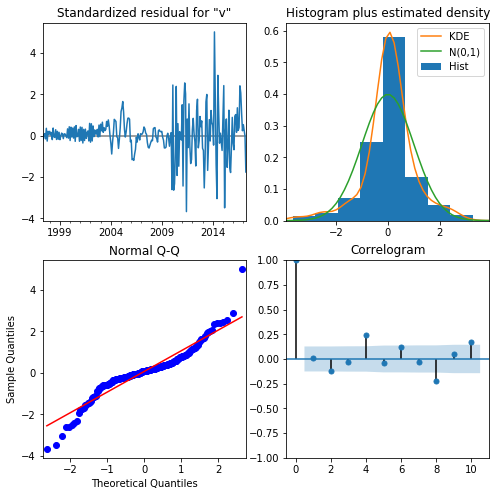

In [55]:
# Run time series through function to fit SARIMAX model using best params 
# Pierson
pierson_output = fit_sarimax_model(pierson_train, pierson_test, order=(2,0,1), 
                                   seasonal_order=(0,0,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  240
Model:             SARIMAX(4, 1, 0)x(2, 0, 0, 12)   Log Likelihood                 951.282
Date:                            Mon, 31 Oct 2022   AIC                          -1888.564
Time:                                    21:19:55   BIC                          -1864.229
Sample:                                05-01-1997   HQIC                         -1878.757
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6268      0.058     28.160      0.000       1.514       1.740
ar.L2         -1.2858      0.095    -13.551      0.000      -1.472      -1.100
ar.L3          0.7378      0.094      7.815      0.000       0.553       0.923
ar.L4         -0.1551      0.053     -2.939      0.003      -0.259      -0.052
ar.S.L12      -0.5283      0.054     -9.872      0.000      -0.633      -0.423
ar.S.L24      -0.3171      0.058     -5.507      0.000      -0.430      -0.204
sigma2      1.978e-05   1.36e-06     14.517      0.000    1.71e-05    2.24e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                50.30
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):              10.82   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.01 percentage points


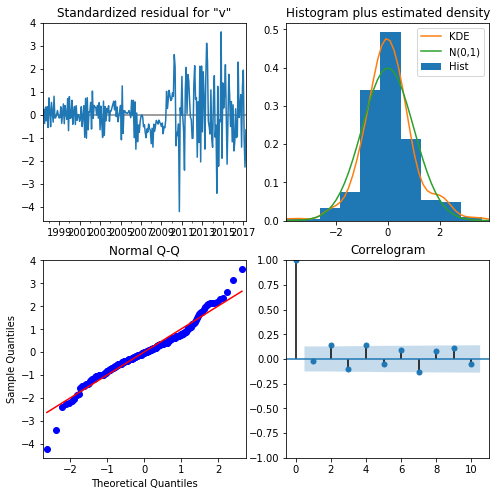

In [56]:
## Egypt Lake Leto
# Run time series through function to fit SARIMAX model using best params 
egyptlakeleto_output = fit_sarimax_model(egyptlakeleto_train, 
                                         egyptlakeleto_test, order=(4,1,0), 
                                         seasonal_order=(2,0,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  240
Model:             SARIMAX(4, 1, 0)x(1, 0, 0, 12)   Log Likelihood                1014.588
Date:                            Mon, 31 Oct 2022   AIC                          -2017.175
Time:                                    21:19:56   BIC                          -1996.316
Sample:                                05-01-1997   HQIC                         -2008.770
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3133      0.050     26.012      0.000       1.214       1.412
ar.L2         -0.6897      0.086     -8.059      0.000      -0.857      -0.522
ar.L3          0.4525      0.087      5.200      0.000       0.282       0.623
ar.L4         -0.1868      0.056     -3.330      0.001      -0.297      -0.077
ar.S.L12      -0.5727      0.048    -11.952      0.000      -0.667      -0.479
sigma2      1.167e-05   1.02e-06     11.401      0.000    9.67e-06    1.37e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                10.01
Prob(Q):                              0.49   Prob(JB):                         0.01
Heteroskedasticity (H):               3.58   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.01 percentage points


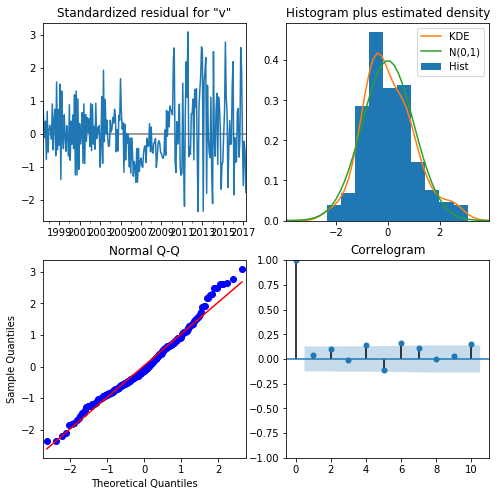

In [57]:
## St. Petersberg
# Run time series through function to fit SARIMAX model using best params 
stpete_output = fit_sarimax_model(stpete_train, stpete_test, order=(4,1,0), 
                                   seasonal_order=(1,0,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  240
Model:               SARIMAX(4, 0, 0)   Log Likelihood                 916.574
Date:                Mon, 31 Oct 2022   AIC                          -1823.148
Time:                        21:19:56   BIC                          -1805.745
Sample:                    05-01-1997   HQIC                         -1816.136
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3393      0.042     56.082      0.000       2.258       2.421
ar.L2         -2.0910      0.103    -20.374      0.000      -2.292      -1.890
ar.L3          1.0746      0.105     10.234      0.000       0.869       1.280
ar.L4         -0.3287      0.043     -7.625      0.000      -0.413      -0.244
sigma2       2.71e-05    1.8e-06     15.019      0.000    2.36e-05    3.06e-05
===================================================================================
Ljung-Box (L1) (Q):                   3.70   Jarque-Bera (JB):                86.98
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              20.88   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.05 percentage points


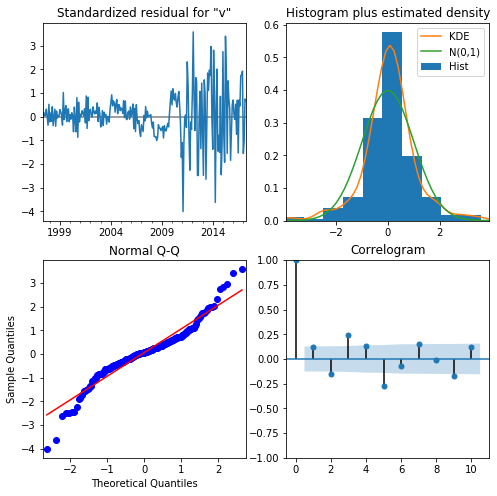

In [58]:
## Orlando
# Run time series through function to fit SARIMAX model using best params 
orlando_output = fit_sarimax_model(orlando_train, orlando_test, order=(4,0,0), 
                                   seasonal_order=(0,0,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  240
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 12)   Log Likelihood                 981.049
Date:                              Mon, 31 Oct 2022   AIC                          -1952.097
Time:                                      21:19:57   BIC                          -1934.715
Sample:                                  05-01-1997   HQIC                         -1945.092
                                       - 04-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7548      0.041     18.305      0.000       0.674       0.836
ma.L1          0.9034      0.050     18.080      0.000       0.805       1.001
ma.L2          0.3312      0.054      6.105      0.000       0.225       0.438
ma.S.L12      -0.3656      0.060     -6.091      0.000      -0.483      -0.248
sigma2       1.56e-05   1.21e-06     12.896      0.000    1.32e-05     1.8e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                52.77
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):              15.66   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.02 percentage points


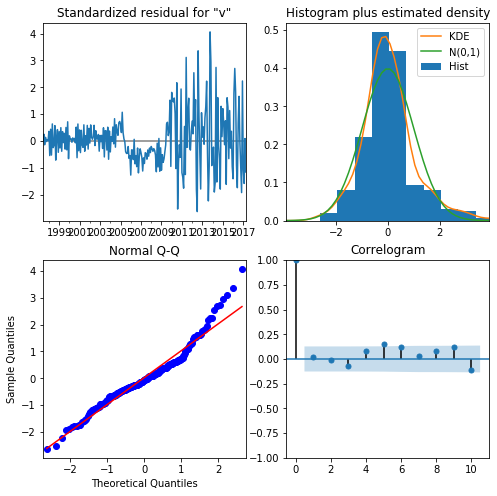

In [59]:
## Bradenton
# Run time series through function to fit SARIMAX model using best params 
bradenton_output = fit_sarimax_model(bradenton_train, bradenton_test, 
                                     order=(1,1,2), seasonal_order=(0,0,1,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                 899.385
Date:                             Mon, 31 Oct 2022   AIC                          -1790.769
Time:                                     21:19:57   BIC                          -1776.863
Sample:                                 05-01-1997   HQIC                         -1785.165
                                      - 04-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8743      0.031     28.413      0.000       0.814       0.935
ma.L1          0.6659      0.046     14.453      0.000       0.576       0.756
ar.S.L12      -0.4809      0.047    -10.197      0.000      -0.573      -0.388
sigma2      3.074e-05   1.99e-06     15.421      0.000    2.68e-05    3.46e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                51.54
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               8.37   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.03 percentage points


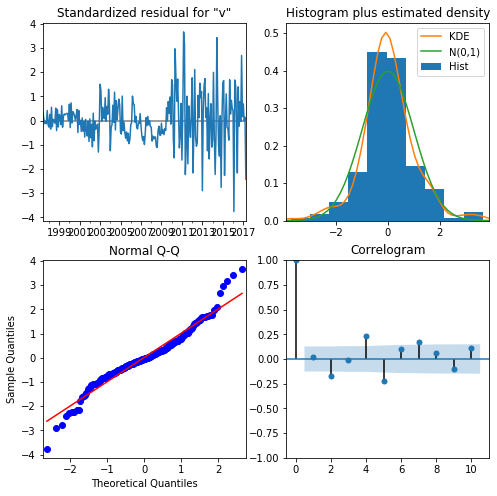

In [60]:
## Pompano Beach
# Run time series through function to fit SARIMAX model using best params 
pompanobeach_output = fit_sarimax_model(pompanobeach_train, pompanobeach_test,
                                        order=(1,1,1), seasonal_order=(1,0,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  240
Model:               SARIMAX(4, 0, 0)   Log Likelihood                 706.978
Date:                Mon, 31 Oct 2022   AIC                          -1403.956
Time:                        21:19:58   BIC                          -1386.553
Sample:                    05-01-1997   HQIC                         -1396.944
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4831      0.034     72.325      0.000       2.416       2.550
ar.L2         -2.6463      0.077    -34.518      0.000      -2.797      -2.496
ar.L3          1.6503      0.078     21.235      0.000       1.498       1.803
ar.L4         -0.5040      0.036    -14.072      0.000      -0.574      -0.434
sigma2         0.0002   8.75e-06     17.878      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   5.35   Jarque-Bera (JB):               124.27
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              14.04   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.07 percentage points


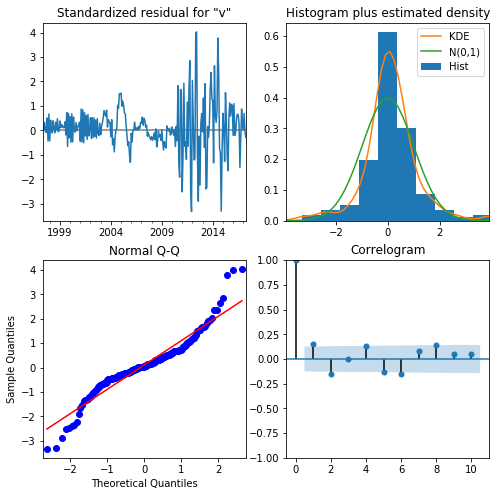

In [61]:
## Jacksonville
# Run time series through function to fit SARIMAX model using best params 
jacksonville_output = fit_sarimax_model(jacksonville_train, jacksonville_test,
                                        order=(4,0,0), seasonal_order=(0,0,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  240
Model:             SARIMAX(4, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 974.098
Date:                            Mon, 31 Oct 2022   AIC                          -1936.197
Time:                                    21:19:58   BIC                          -1915.338
Sample:                                05-01-1997   HQIC                         -1927.791
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5422      0.061     25.242      0.000       1.422       1.662
ar.L2         -1.0759      0.108     -9.966      0.000      -1.288      -0.864
ar.L3          0.5513      0.106      5.212      0.000       0.344       0.759
ar.L4         -0.1002      0.059     -1.701      0.089      -0.216       0.015
ar.S.L12      -0.5222      0.044    -11.815      0.000      -0.609      -0.436
sigma2      1.642e-05   1.16e-06     14.103      0.000    1.41e-05    1.87e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.65
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               7.09   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.07 percentage points


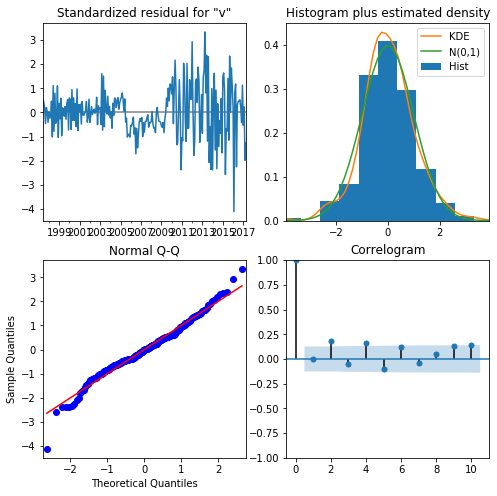

In [62]:
## West Palm Beach
# Run time series through function to fit SARIMAX model using best params 
westpalmbeach_output = fit_sarimax_model(westpalmbeach_train, westpalmbeach_test,
                                         order=(4,1,0), seasonal_order=(1,0,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                  240
Model:             SARIMAX(3, 1, 2)x(1, 0, [], 12)   Log Likelihood                 930.629
Date:                             Mon, 31 Oct 2022   AIC                          -1847.258
Time:                                     21:19:59   BIC                          -1822.923
Sample:                                 05-01-1997   HQIC                         -1837.452
                                      - 04-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6291      0.082      7.677      0.000       0.468       0.790
ar.L2         -0.3093      0.076     -4.085      0.000      -0.458      -0.161
ar.L3          0.5430      0.052     10.542      0.000       0.442       0.644
ma.L1          0.7858      0.086      9.137      0.000       0.617       0.954
ma.L2          0.2398      0.078      3.059      0.002       0.086       0.393
ar.S.L12      -0.5405      0.035    -15.482      0.000      -0.609      -0.472
sigma2      2.353e-05    1.5e-06     15.669      0.000    2.06e-05    2.65e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               140.34
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              10.94   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.07 percentage points


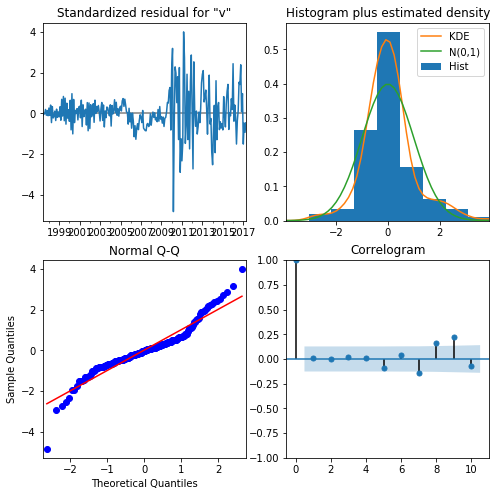

In [63]:
## Lockhart
# Run time series through function to fit SARIMAX model using best params 
lockhart_output = fit_sarimax_model(lockhart_train, lockhart_test, order=(3,1,2), 
                                   seasonal_order=(1,0,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  240
Model:             SARIMAX(4, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 963.860
Date:                            Mon, 31 Oct 2022   AIC                          -1915.719
Time:                                    21:20:00   BIC                          -1894.861
Sample:                                05-01-1997   HQIC                         -1907.314
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5000      0.046     32.943      0.000       1.411       1.589
ar.L2         -1.0688      0.084    -12.738      0.000      -1.233      -0.904
ar.L3          0.7929      0.085      9.350      0.000       0.627       0.959
ar.L4         -0.3198      0.049     -6.506      0.000      -0.416      -0.223
ar.S.L12      -0.6748      0.034    -20.133      0.000      -0.741      -0.609
sigma2      1.702e-05   1.27e-06     13.375      0.000    1.45e-05    1.95e-05
===================================================================================
Ljung-Box (L1) (Q):                   3.75   Jarque-Bera (JB):                14.35
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               9.59   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Root Mean Squared Error of predictions is 0.09 percentage points


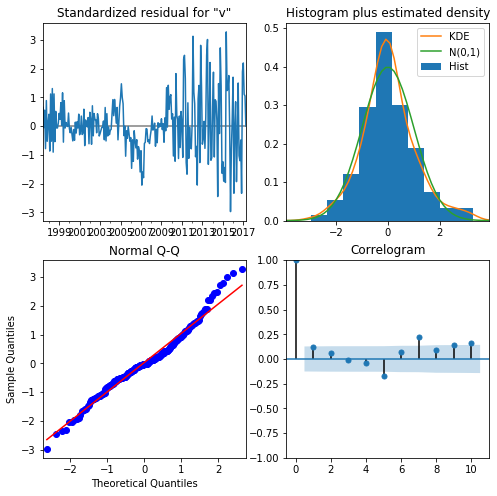

In [64]:
## Port Charlotte
# Run time series through function to fit SARIMAX model using best params 
portcharlotte_output = fit_sarimax_model(portcharlotte_train, portcharlotte_test,
                                         order=(4,1,0), seasonal_order=(1,0,0,12))

- Residuals appear to be generally random, with no clear patterns.
- Six models with lowest AIC, RMSE: Pierson, Egypt Lake Leto, St. Petersberg,  
Orlando, Bradenton,  and Pompano Beach. 
- Four zipcodes with higher RMSE (Jacksonville, West Palm Beach, Lockhart,  
and Port Charlotte) will not be included in forecasting.

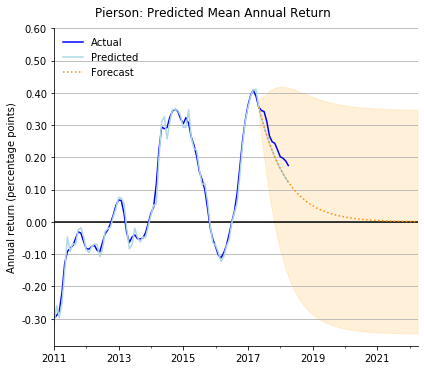

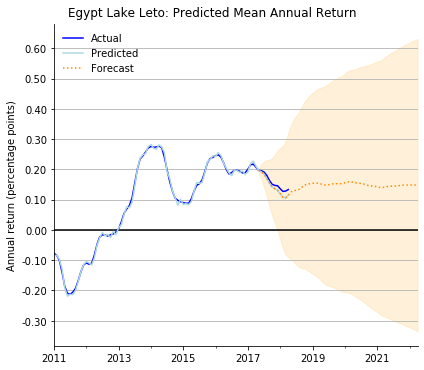

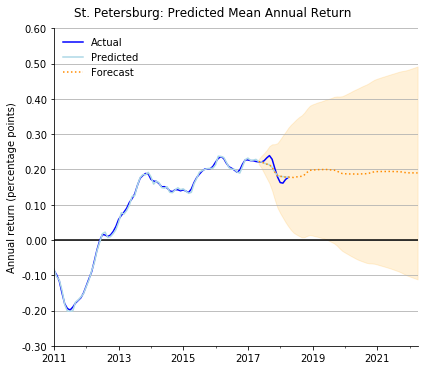

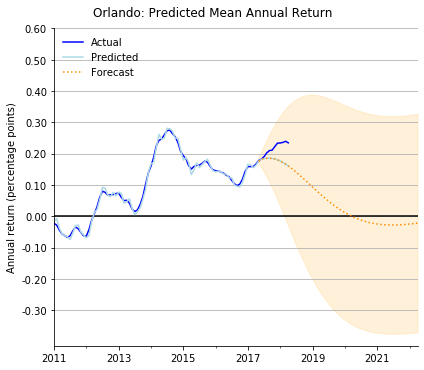

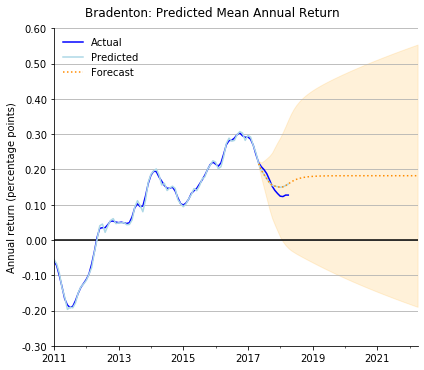

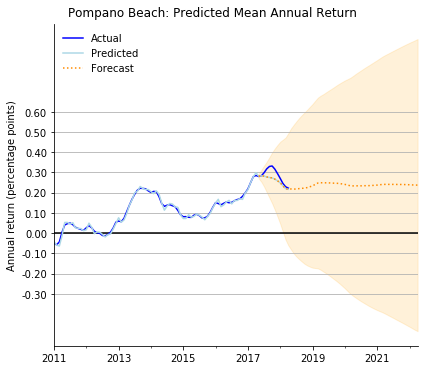

In [65]:
# Forecast prices for select zipcodes
# Create lists for train_df, test_df, output, and names of select zipcodes

dfs_train = [pierson_train, egyptlakeleto_train, stpete_train,
                        orlando_train, bradenton_train,
                       pompanobeach_train]

dfs_test = [pierson_test, egyptlakeleto_test, stpete_test,
                        orlando_test, bradenton_test,
                       pompanobeach_test]

list_names = ['Pierson', 'Egypt Lake Leto', 'St. Petersburg', 'Orlando',
                    'Bradenton', 'Pompano Beach']

list_output = [pierson_output, egyptlakeleto_output, stpete_output,
                        orlando_output, bradenton_output,
                       pompanobeach_output]

# Loop through select zipcodes to forecast price
for i, df in enumerate(dfs_train):
    get_forecasts(list_names[i], dfs_train[i], dfs_test[i],
                  list_output[i], steps=60)

## Interpreting Results

In [66]:
# Compare mean forecasts for select zipcodes
forecasts_list = []
cityzip_list = ['Pierson_32180',
 'Egypt Lake Leto_33614',
 'St. Petersburg_33713',
 'Orlando_32839',
 'Bradenton_34205',
 'Pompano Beach_33069']

for i, output in enumerate(list_output):
    forecasts = output.get_forecast(steps=60, dynamic=True)
    forecasts_list.append(forecasts.summary_frame().mean())
    forecasts_names = pd.Series(cityzip_list)
    forecasts_df = pd.DataFrame(forecasts_list)
    forecasts_df['name'] = forecasts_names
    forecasts_df.set_index('name', inplace=True)

forecasts_df

value,mean,mean_se,mean_ci_lower,mean_ci_upper
name,,,,
Pierson_32180,0.064027,0.158130,-0.245902,0.373956
Egypt Lake Leto_33614,0.147542,0.162434,-0.170822,0.465907
St. Petersburg_33713,0.192842,0.102616,-0.008281,0.393965
Orlando_32839,0.054542,0.143117,-0.225961,0.335046
Bradenton_34205,0.178061,0.131263,-0.079210,0.435332
Pompano Beach_33069,0.241484,0.233444,-0.216058,0.699027


- Egypt Lake Leto, St. Petersberg, Bradenton, Palm Beach have combination of lower RMSE and  
higher returns. Of these, the St. Petersberg and Bradenton forecasts stand out as outperformers  
for having lowest RMSE and second-highest returns. Pompano Beach has highest forecasted returns,  
but it also has a higher RMSE. RMSE results are shown in above model outputs.
- Confidence intervals are wide for all forecasts, indicating that uncertainty is high and there is room  
to further improve the models.

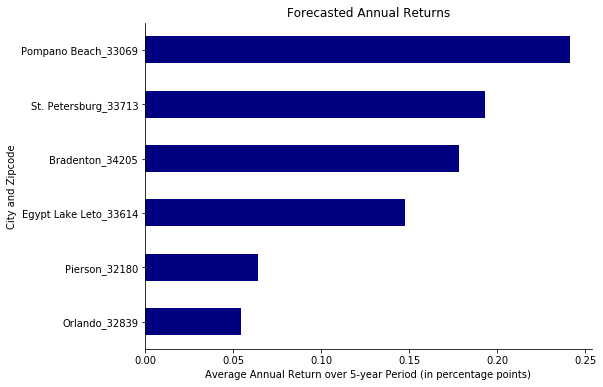

In [67]:
# Plot forecasted annual returns over 5y period
# Create figure and set size
fig, ax = plt.subplots(figsize=(8,6))
# Plot mean forecasted returns
forecasts_df['mean'].sort_values(ascending=True).plot(kind='barh', color='navy',
                                                      ax=ax)

# Format axes
plt.ylabel('City and Zipcode')
plt.xlabel('Average Annual Return over 5-year Period (in percentage points)')

# Remove top, right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set title
plt.title('Forecasted Annual Returns')
plt.show()

## Recommendations

Based on the results, four zipcodes in Pompano Beach (Miami-Ft.Lauderdale metro area),  
Bradenton (North Port-Sarasota-Bradenton), St. Peterburg (Tampa metro area), and Egypt Lake  
Leto (Tampa metro area) are recommended 5-year investments. These zipcodes have sales prices  
below the state median of $226k, and forecasted average annual returns in the 15%-25% range.  
Pierson and Orlando zipcodes are not recommended investments--the model forecasts lower returns  
and a higher model error compared to the other four zipcodes.

Since forecasts are based only on historical returns, model improvements should take into  
account other external factors (such as mortgage rates and economic indicators) and evaluate  
model performance to improve forecast quality. Furthermore, this analysis intentionally focused  
on the full historical dataset and did not focus exclusively on the post-housing crisis period;  
further model iterations could explore results using data from 2011 onwards.